# Tutorial on running pgs

Stephen Arrowsmith (sarrowsmith@smu.edu)

In [1]:
import numpy
import pgs, datetime, toml, pickle
import pandas as pd
from obspy import UTCDateTime
from pyproj import Geod
from matplotlib.dates import date2num, num2date

## Creating a synthetic event

PGS takes a TOML file as the input. You can make this in a text editor. The following two blocks create a TOML file for a synthetic event, optionally adding perturbations to the synthetic measurements.

The parameters are as follows:
- model_file: The name of the binary file where predicted traveltimes and backazimuths are stored
- earth_model: The name of the Earth model in ObsPy (for built-in options, or instructions on how to build your own, see: https://docs.obspy.org/packages/obspy.taup.html)
- bounds: Geographic limits of the grid search
- N_lon: Number of grid points in longitude
- N_lat: Number of grid points in latitude
- N_d: Number of grid points in depth
- stnm: Names of stations or arrays
- stla: Latitudes of stations or arrays
- stlo: Longitudes of stations or arrays
- t_start: Start time over which to search
- t_end: End time over which to search
- N_t: Number of origin times

In [2]:
config = '''
model_file = "SYNTH1.model"
earth_model = "ak135"

[grid]
bounds = [-97.78, -97.57, 36.57, 36.66, 0.0, 10.0]
N_lon = 40
N_lat = 40
N_d = 20

[stations]
stnm = ['STN1', 'STN2', 'STN3']
stla = [36.6153, 36.617, 36.581]
stlo = [-97.733, -97.601, -97.662]

[time-grid]
t_start = '2016/01/01 11:59:59.500000'
t_end = '2016/01/01 12:00:00.500000'
N_t = 48

[ampParams]
wavetype = 'surface'
frequency = 3
beta = 2.2
Q = 200
'''

config = toml.loads(config)

In [3]:
import importlib
importlib.reload(pgs)
# Defining source location:
evla = 36.635; evlo = -97.714; evdp = 2.
evt0 = date2num(datetime.datetime(2016,1,1,12,0,0))
# Defining the indices of stations in (1) to use:
pgs.compute_predictions(config, evla, evlo, evdp, evt0, std_p=0, std_s=0, std_b=0, std_a=0)

## Locating the synthetic event

The following set of blocks solve for the event location given a TOML file. The first block reads in the TOML file as the configuration variable config:

In [4]:
config = toml.load('SYNTH1.toml')

Next, we compute the predicted arrival times and backazimuths from all the possible event hypotheses (defined by the latitude, longitude, depth, and time) to all the stations. Depending on the number of grid points used in the search, this could take a while. However, it only needs to be run one time for a single configuration (new events with the same station configuration can be located with the same model file).

The parameters are as follows:
- del_dist defines the spacing in kilometers between each point on the travel time curve. The smaller this number the greater the accuracy at the cost of computation time.

In [5]:
pgs.make_model_file(config, del_dist=0.1)

The next block solves for the likelihood over the full model space. The parameters are as follows:
- t_std_in defines the a-priori estimate of the standard deviation in arrival time
- b_std_in defines the a-priori estimate of the standard deviation in backazimuth
- use_p_in is a Boolean that defines whether to use P-wave arrival times (if available)
- use_s_in is a Boolean that defines whether to use S-wave arrival times (if available)
- use_b_in is a Boolean that defines whether to use backazimuths (if available)

In [6]:
likl = pgs.do_location(config, t_std=0.2, b_std=13, use_p=True, use_s=True, use_b=True)

The next block plots the marginal distributions. You may have to play with the variables aspect1 and aspect2 to get the subplots to line up suitably, depending on the dimensions of the search area.

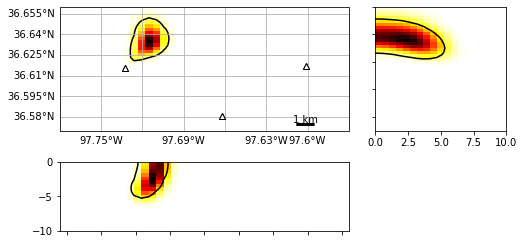

In [7]:
pgs.plot_marginal_distributions(config, likl,
                                   aspect1=105, aspect2=0.005,
                                   plot_maxlikl=False, plot_true=False,
                                   cmap='hot_r', scale_bar_length=1, cred=0.9,
                                   do_smoothing=True, smoothing_width=0.5, plot_baz=False)

Using backazimuth only

In [8]:
likl = pgs.do_location(config, t_std=0.2, b_std=5, use_p=True, use_s=True, use_b=True)

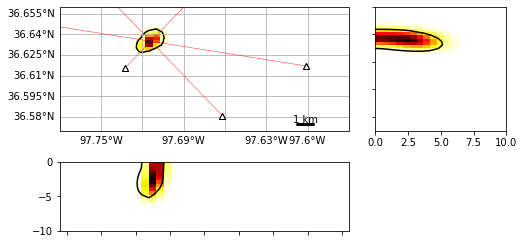

In [9]:
pgs.plot_marginal_distributions(config, likl,
                                   aspect1=105, aspect2=0.005,
                                   plot_maxlikl=False, plot_true=False,
                                   cmap='hot_r', scale_bar_length=1, cred=0.9,
                                   do_smoothing=True, smoothing_width=0.5, plot_baz=True)

In [10]:
likl = pgs.do_location(config, t_std=0.2, b_std=5, a_std=0.01, use_p=False, use_s=False, use_b=False, use_a=True)

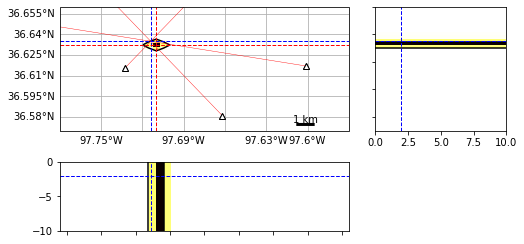

In [11]:
evla = 36.635; evlo = -97.714; evdp = 2.
pgs.plot_marginal_distributions(config, likl,
                                   aspect1=105, aspect2=0.005,
                                   plot_maxlikl=True, plot_true=True,
                                   evla=evla, evlo=evlo, evdp=evdp,
                                   cmap='hot_r', scale_bar_length=1, cred=0.9,
                                   do_smoothing=True, smoothing_width=0.5, plot_baz=True)

In [12]:
likl = pgs.do_location(config, t_std=0.2, b_std=5, a_std=0.05, use_p=True, use_s=True, use_b=True, use_a=True)

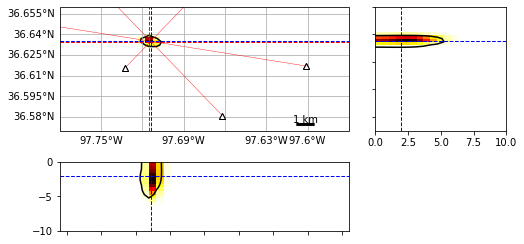

In [13]:
evla = 36.635; evlo = -97.714; evdp = 2.
pgs.plot_marginal_distributions(config, likl,
                                   aspect1=105, aspect2=0.005,
                                   plot_maxlikl=True, plot_true=True,
                                   evla=evla, evlo=evlo, evdp=evdp,
                                   cmap='hot_r', scale_bar_length=1, cred=0.9,
                                   do_smoothing=True, smoothing_width=0.5, plot_baz=True)
